In [230]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
# mpl.rcParams['figure.dpi'] = 300
import math
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [247]:
df = df_dow.copy()

df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'UNH','MCD'])]
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-01-01'
INDICATORS = [
    "macd",
    "rsi_30",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 6


In [ ]:
cleaned_data['std_return_60'] = cleaned_data.groupby('tic')['log_return'].ewm(span=60,ignore_na=False,
            min_periods=1).std().reset_index(level=0,drop=True)
cleaned_data['ewma_std_price_63'] = cleaned_data.groupby('tic')['close'].ewm(span=63,ignore_na=False,
            min_periods=1).std().reset_index(level=0,drop=True)

cleaned_data['macd_normalized'] = cleaned_data['macd'] / cleaned_data['ewma_std_price_63'] 
cleaned_data['macd_std'] = cleaned_data.groupby('tic')['macd_normalized'].ewm(span=252,ignore_na=False,
            min_periods=1).std().reset_index(level=0,drop=True)

cleaned_data['macd_normal'] = cleaned_data['macd_normalized'] / cleaned_data['macd_std']
cleaned_data['rsi_normal'] = cleaned_data['rsi_30'] /100
cleaned_data['price_lag_5'] = cleaned_data.groupby('tic')['log_return'].rolling(window=5, min_periods=5).sum().reset_index(level=0, drop=True)
cleaned_data['price_lag_21'] = cleaned_data.groupby('tic')['log_return'].rolling(window=21, min_periods=21).sum().reset_index(level=0, drop=True)
cleaned_data['price_lag_42'] = cleaned_data.groupby('tic')['log_return'].rolling(window=42, min_periods=42).sum().reset_index(level=0, drop=True)
cleaned_data['price_lag_63'] = cleaned_data.groupby('tic')['log_return'].rolling(window=63, min_periods=63).sum().reset_index(level=0, drop=True)
cleaned_data['price_lag_252'] = cleaned_data.groupby('tic')['log_return'].rolling(window=252, min_periods=252).sum().reset_index(level=0, drop=True)

cleaned_data['r_21_normal'] = cleaned_data['price_lag_21'] / (cleaned_data['std_return_60'] )
cleaned_data['r_42_normal'] = cleaned_data['price_lag_42'] / (cleaned_data['std_return_60'] )
cleaned_data['r_63_normal'] = cleaned_data['price_lag_63'] / (cleaned_data['std_return_60'] )
cleaned_data['r_252_normal'] = cleaned_data['price_lag_252'] / (cleaned_data['std_return_60']) 


In [246]:
cleaned_data

,Unnamed: 0,date,open,high,low,close,volume,tic,day,macd,...,rsi_normal,price_lag_5,price_lag_21,price_lag_42,price_lag_63,price_lag_252,momentum_return_21_normal,momentum_return_42_normal,momentum_return_63_normal,momentum_return_252_normal
0,91618,2013-01-02,58.330002,58.950001,58.310001,49.615555,6091400,AXP,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3019,91624,2013-01-02,50.799999,51.250000,50.639999,45.887764,11674700,DIS,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,91625,2013-01-02,131.300003,131.660004,129.619995,105.272430,4449000,GS,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9057,91633,2013-01-02,89.400002,90.349998,89.330002,65.415565,7377200,MCD,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12076,91634,2013-01-02,78.754181,79.255852,78.561874,54.016647,3835213,MMM,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6037,180601,2024-12-30,110.430000,111.540001,109.830002,110.800003,5716300,DIS,0,0.688713,...,0.569935,-0.011040,-0.055141,0.146447,0.145823,0.212507,-0.903571,1.696885,1.379598,1.005241
9056,180603,2024-12-30,567.270020,576.020020,565.099976,573.549988,1265900,GS,0,-0.740955,...,0.534293,0.013074,-0.049152,0.094761,0.152007,0.418881,-0.565352,0.770712,1.009441,1.390844
12075,180611,2024-12-30,291.470001,291.470001,289.000000,289.600006,1936700,MCD,0,-0.847394,...,0.468390,-0.010579,-0.012748,-0.012477,-0.044206,0.002626,-0.270417,-0.187146,-0.541376,0.016083
15094,180612,2024-12-30,129.119995,129.919998,127.919998,129.130005,2154000,MMM,0,-0.291080,...,0.494727,-0.001161,-0.025612,0.004221,-0.051665,0.376219,-0.390550,0.045510,-0.454850,1.656092


In [233]:

train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 6


In [237]:
cleaned_data

,Unnamed: 0,date,open,high,low,close,volume,tic,day,macd,...,rsi_normal,price_lag_5,price_lag_21,price_lag_42,price_lag_63,price_lag_252,momentum_return_21_normal,momentum_return_42_normal,momentum_return_63_normal,momentum_return_252_normal
0,91618,2013-01-02,58.330002,58.950001,58.310001,49.615555,6091400,AXP,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3019,91624,2013-01-02,50.799999,51.250000,50.639999,45.887764,11674700,DIS,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,91625,2013-01-02,131.300003,131.660004,129.619995,105.272430,4449000,GS,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9057,91633,2013-01-02,89.400002,90.349998,89.330002,65.415565,7377200,MCD,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12076,91634,2013-01-02,78.754181,79.255852,78.561874,54.016647,3835213,MMM,2,0.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6037,180601,2024-12-30,110.430000,111.540001,109.830002,110.800003,5716300,DIS,0,0.688713,...,0.569935,-0.011040,-0.055141,0.146447,0.145823,0.212507,-4.140683,10.997073,10.950216,15.957699
9056,180603,2024-12-30,567.270020,576.020020,565.099976,573.549988,1265900,GS,0,-0.740955,...,0.534293,0.013074,-0.049152,0.094761,0.152007,0.418881,-2.590770,4.994785,8.012188,22.078964
12075,180611,2024-12-30,291.470001,291.470001,289.000000,289.600006,1936700,MCD,0,-0.847394,...,0.468390,-0.010579,-0.012748,-0.012477,-0.044206,0.002626,-1.239205,-1.212845,-4.297040,0.255302
15094,180612,2024-12-30,129.119995,129.919998,127.919998,129.130005,2154000,MMM,0,-0.291080,...,0.494727,-0.001161,-0.025612,0.004221,-0.051665,0.376219,-1.789727,0.294935,-3.610257,26.289639


In [8]:
from pypfopt import expected_returns
from pypfopt import risk_models

def mvo_data(data, TEST_START_DATE, TEST_END_DATE, returns_model='ema_historical_return',risk_model='ledoit_wolf'):
    df = data.sort_values(['date', 'tic'], ignore_index=True).copy()
    df.index = df.date.factorize()[0]
    cov_list = []
    mu = []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        covs = risk_models.risk_matrix(price_lookback,method=risk_model)
        mu.append(expected_returns.return_model(price_lookback,method=returns_model,compounding=False))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
        {'time': df.date.unique()[lookback:], 'cov_list': cov_list, 'returns': mu})
    df = df.merge(df_cov, left_on='date', right_on='time')

    test_df = data_split(
        df,
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )
    return test_df

begin_total_asset:50000
end_total_asset:66387.02964118724
Sharpe:  1.0027244786876415
Test Finished!
episode_return 1.327740592823745


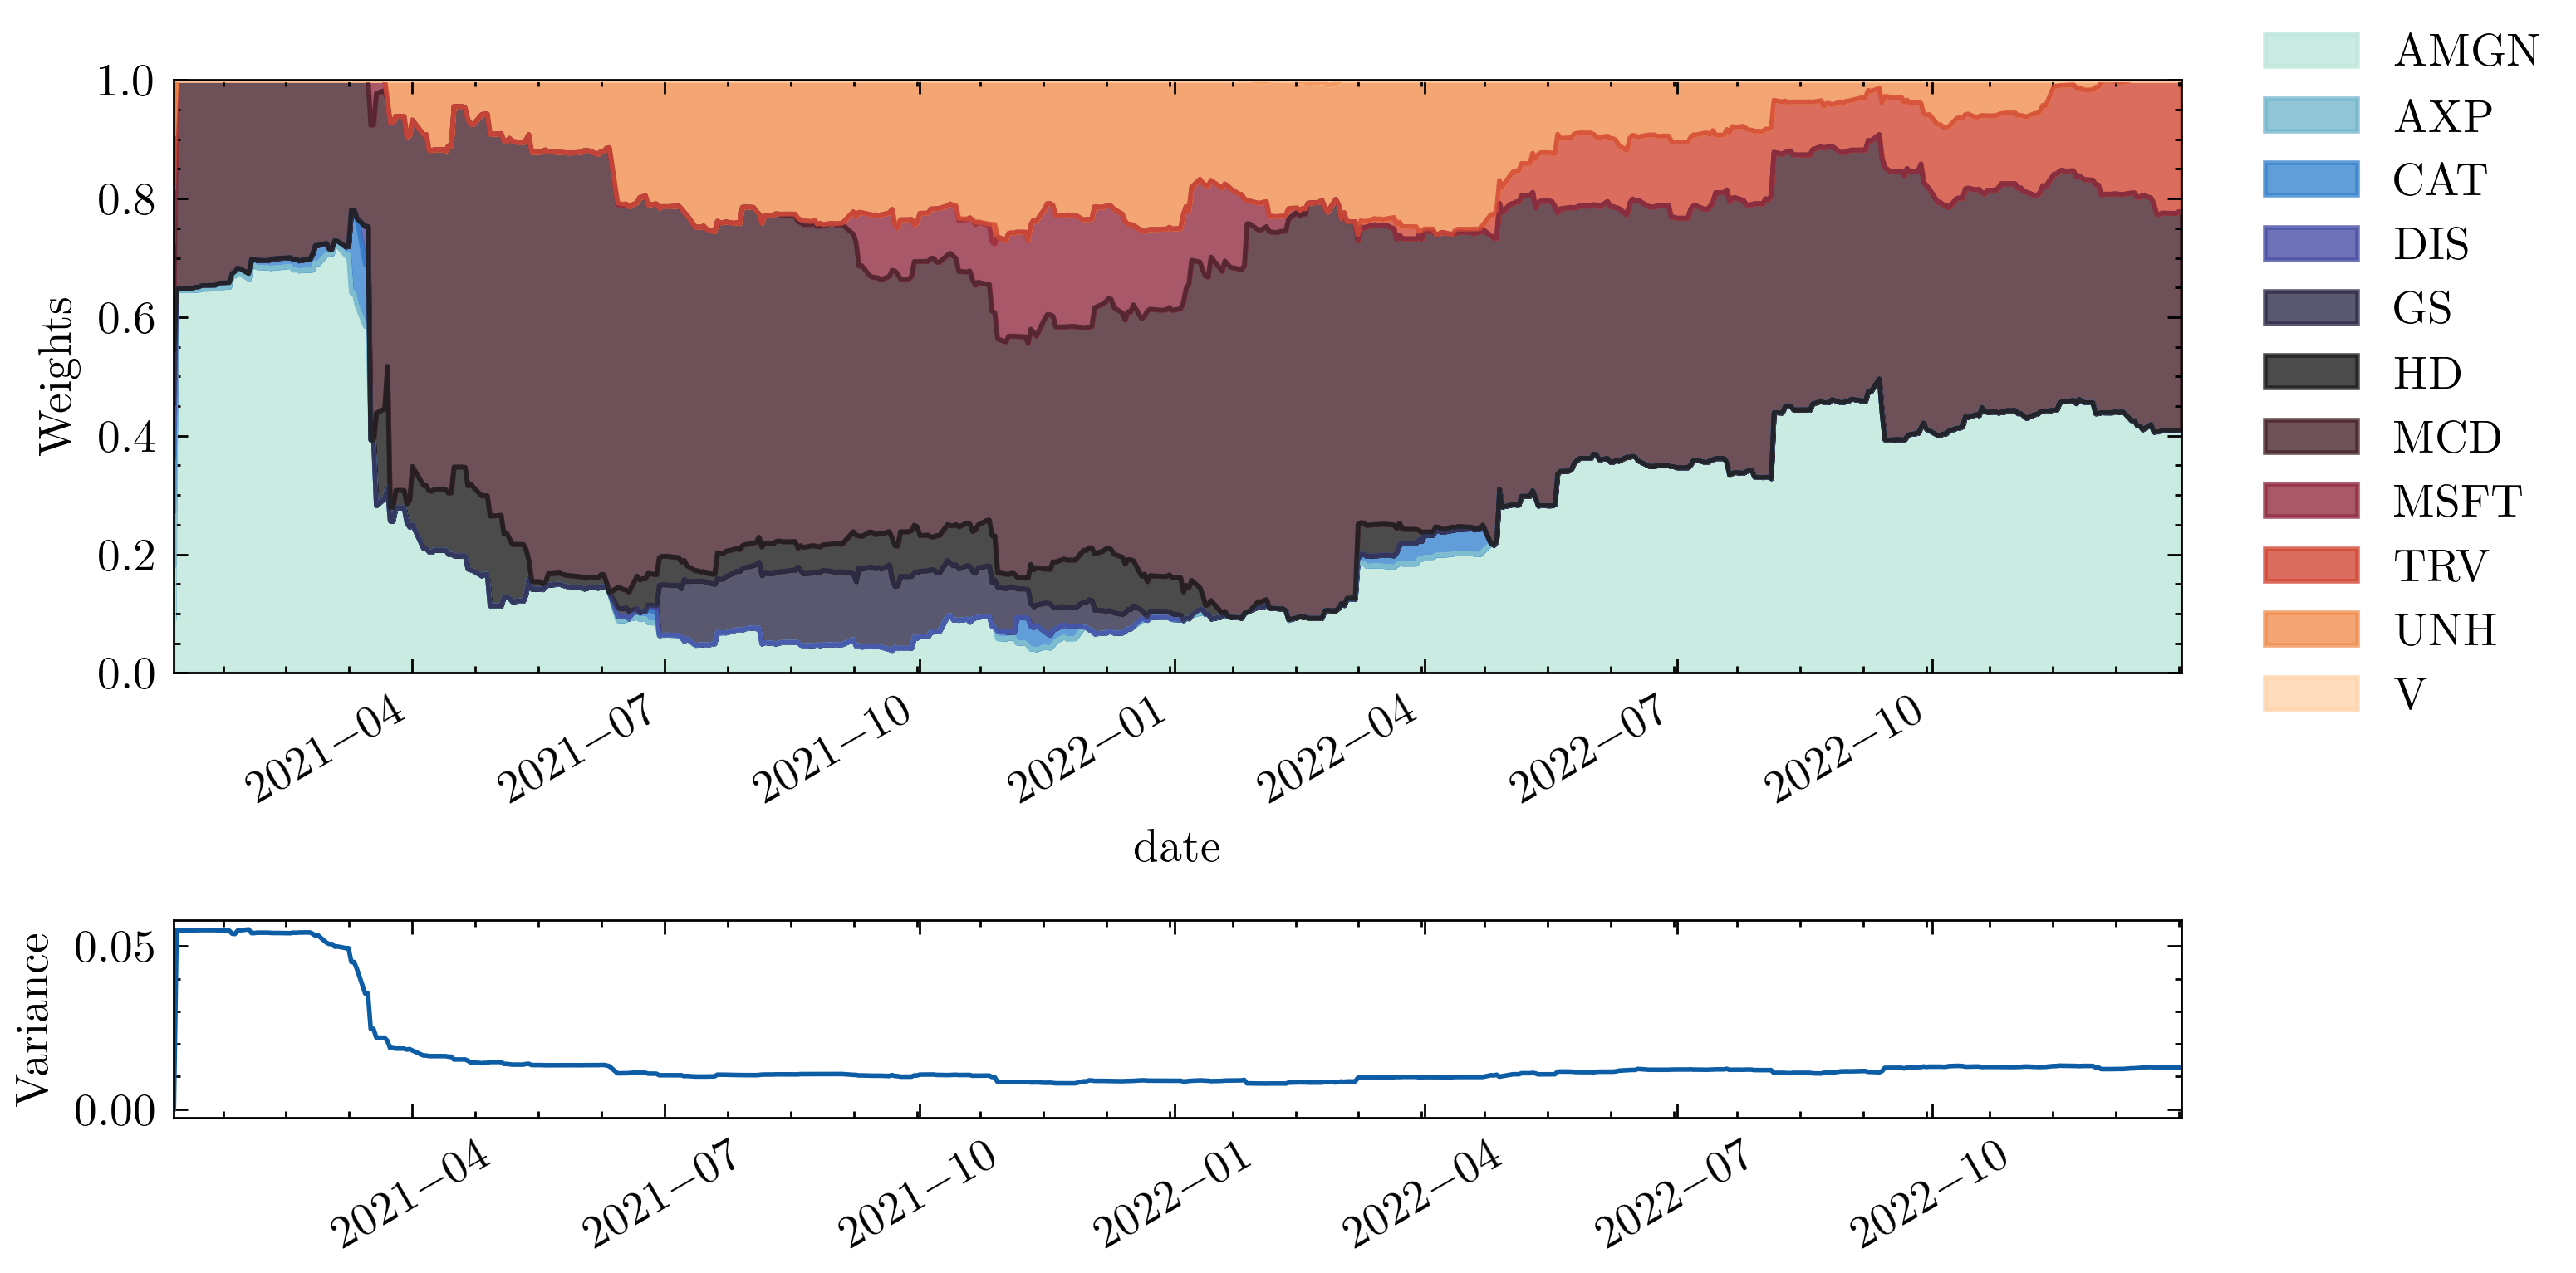

In [15]:
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-01-01'
covariances = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE,returns_model='ema_historical_return',risk_model='semicovariance')
res = mvo.mean_variance_optimization(covariances,pct=0)
%matplotlib inline
plot_mvo_weights(res,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_exponential_semi_cov.png')

In [ ]:
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-01-01'
covariances = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE,returns_model='ema_historical_return',risk_model='exp_cov')
res = mvo.mean_variance_optimization(covariances,pct=0,window=60)
%matplotlib inline
plot_mvo_weights(res,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_exponential_2.png')

In [70]:
TEST_START_DATE = '2021-03-30'
TEST_END_DATE = '2023-01-01'

In [71]:
covariances = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE,returns_model='mean_historical_return',risk_model='sample_cov')

begin_total_asset:50000
end_total_asset:52651.04797799775
Sharpe:  0.26361292645411083
Test Finished!
episode_return 1.053020959559955


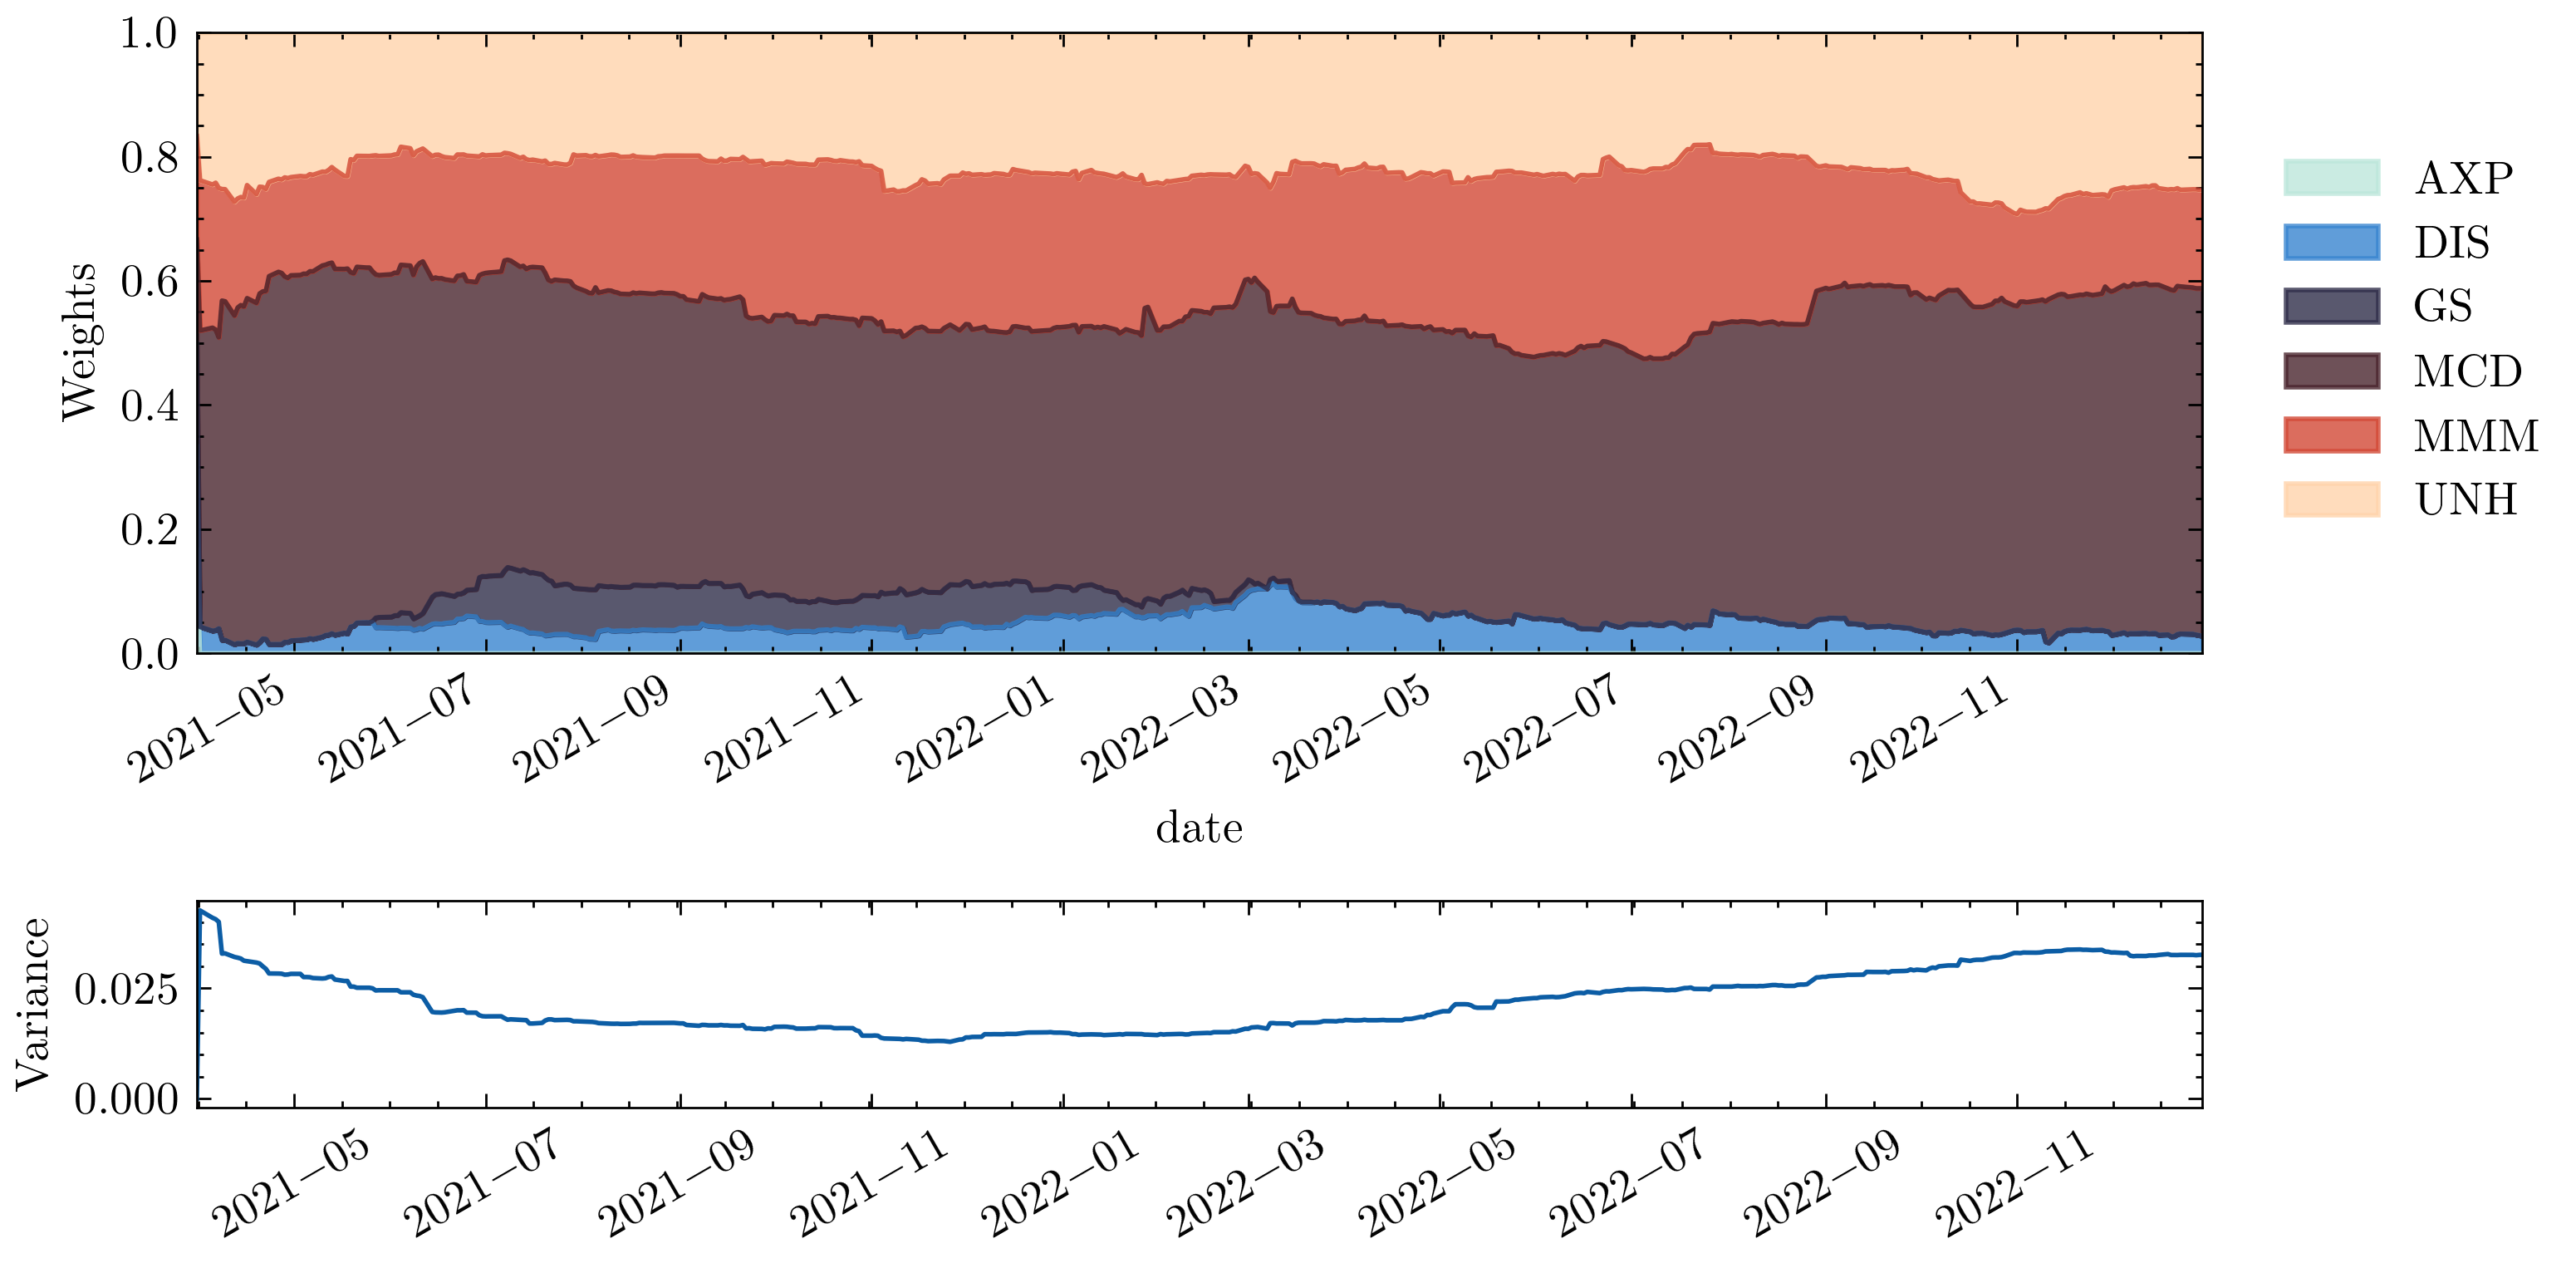

In [72]:
min_variacen_portfolio = mvo.mean_variance_optimization(covariances,pct=0)
%matplotlib inline
plot_mvo_weights(min_variacen_portfolio,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_sample_cov_mean_min_var.png')

begin_total_asset:50000
end_total_asset:60753.65735788175
Sharpe:  0.6669787365905294
Test Finished!
episode_return 1.215073147157635


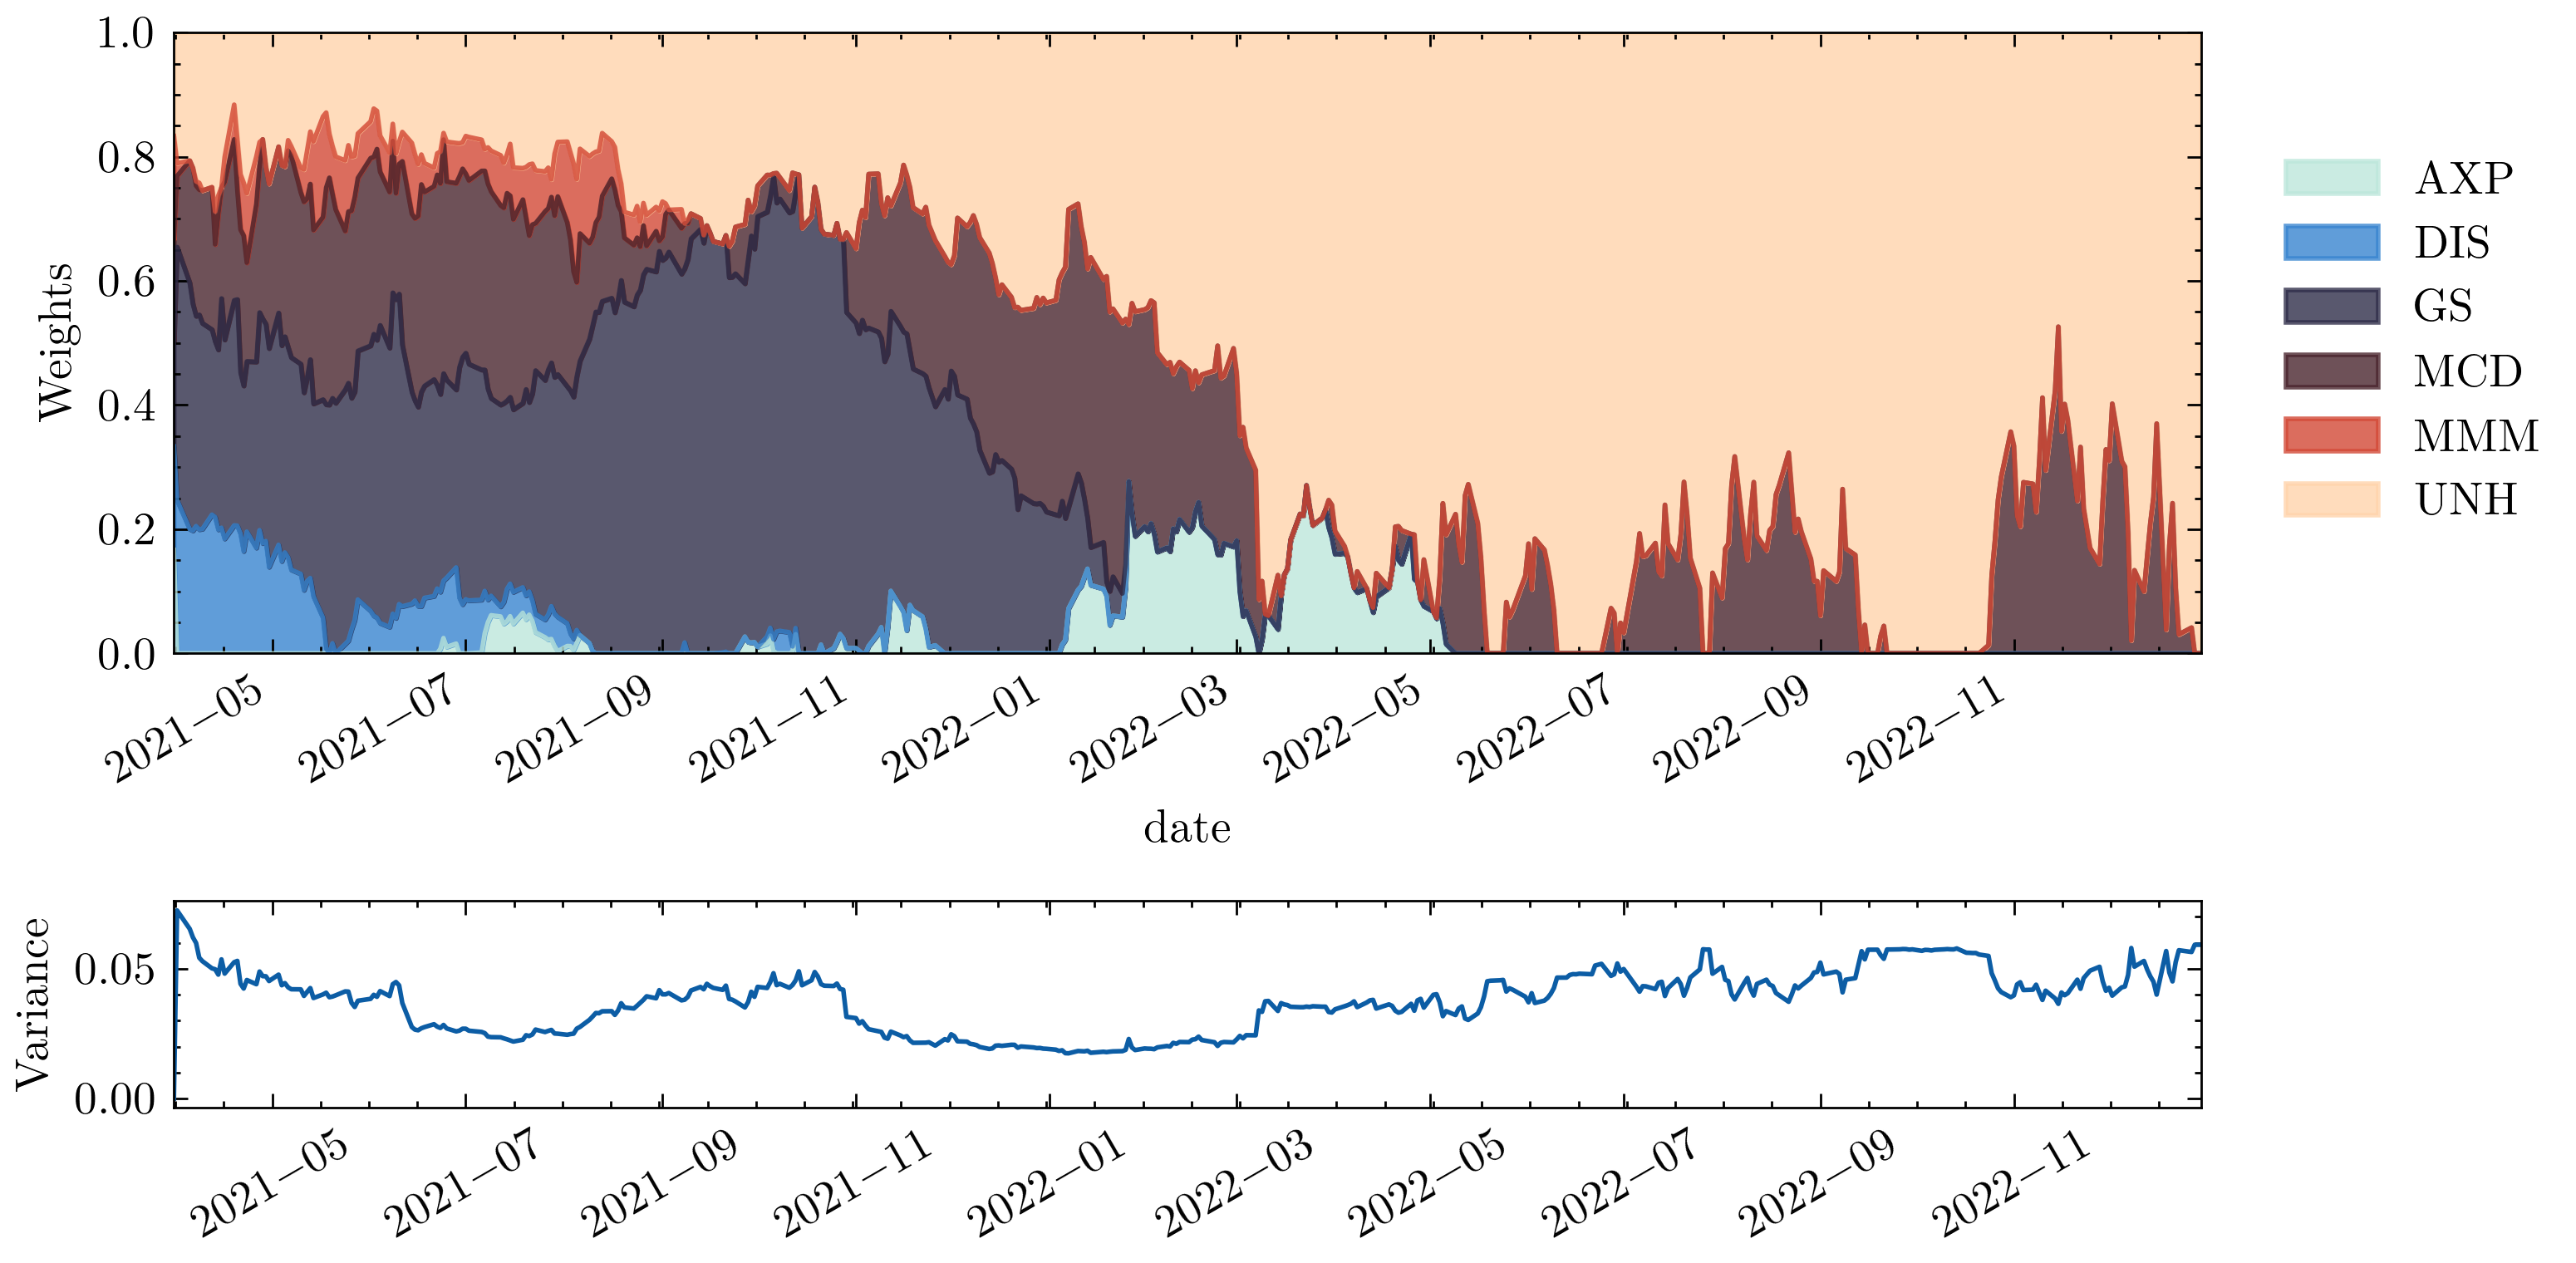

In [73]:
result_sharpe = mvo.mean_variance_optimization(covariances,pct=0,objective='sharpe')
%matplotlib inline
plot_mvo_weights(result_sharpe,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_sample_cov_mean_sharpe.png')

begin_total_asset:50000
end_total_asset:55198.70029408053
Sharpe:  0.34180066743617715
Test Finished!
episode_return 1.1039740058816105


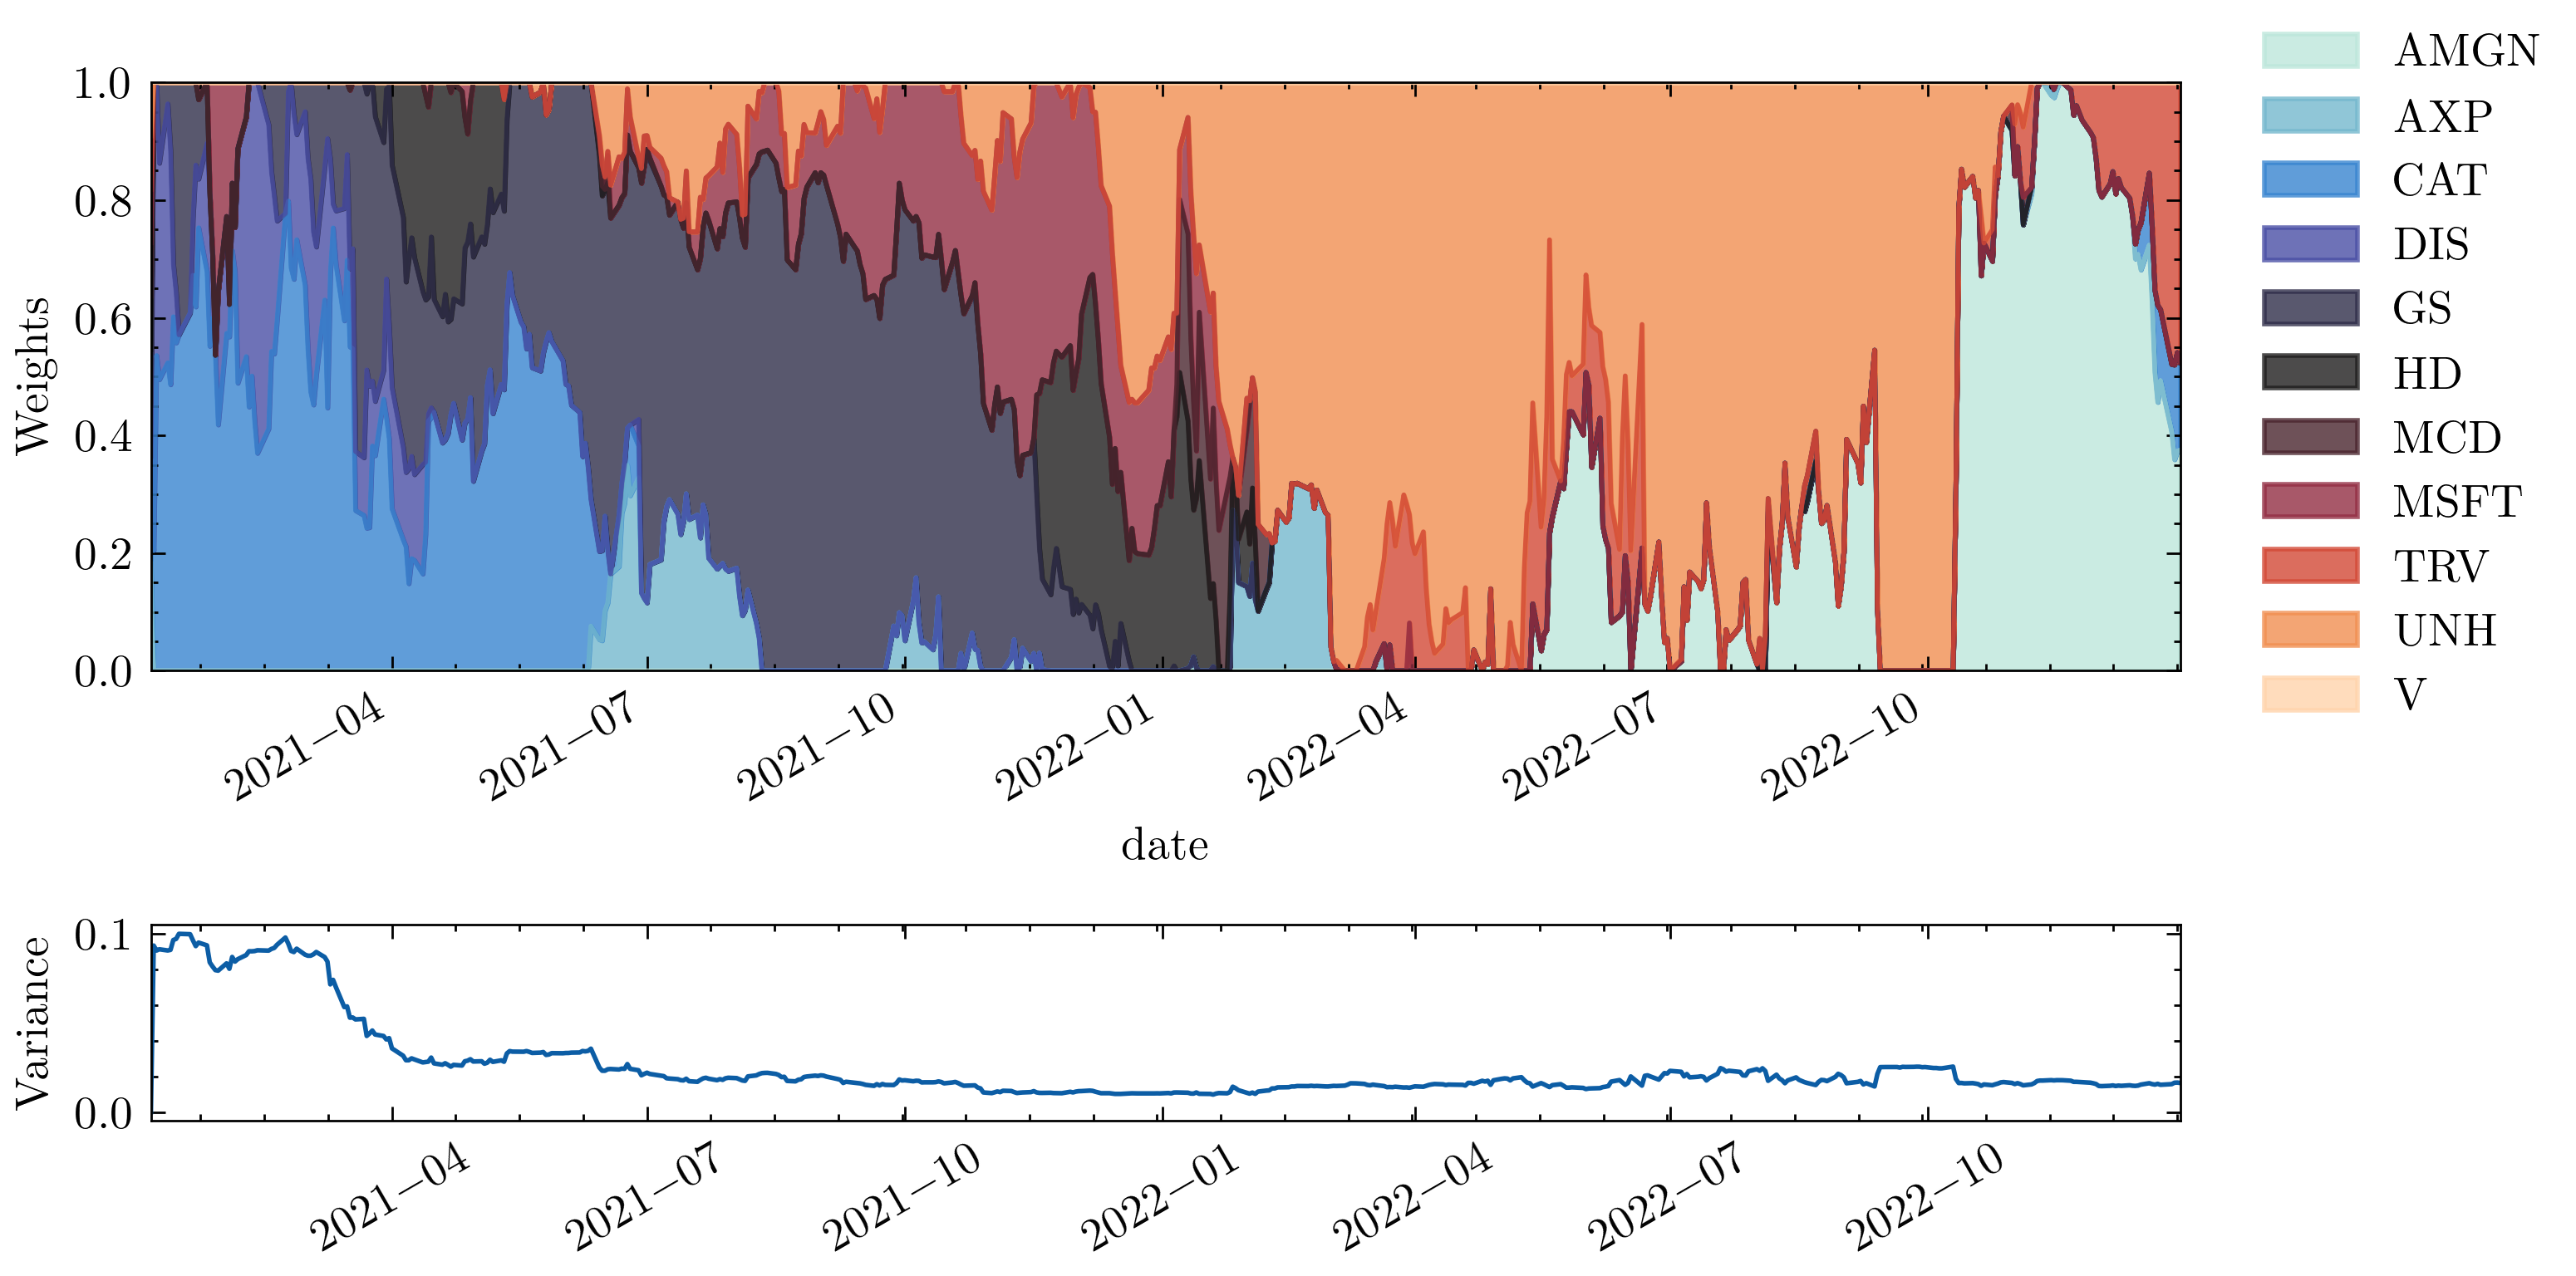

In [ ]:
TEST_START_DATE = '2021-03-30'
TEST_END_DATE = '2023-01-01'
covariances = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE,returns_model='ema_historical_return',risk_model='semicovariance')
res = mvo.mean_variance_optimization(covariances,pct=0,objective='sharpe')
%matplotlib inline
plot_mvo_weights(res,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_exponential_semi_cov_sharpe.png')

PPO WITHOUT WEIGHT

Use normalization

In [22]:
test_data

,Unnamed: 0,date,open,high,low,close,volume,tic,day,macd,...,rsi_normal,price_lag_5,price_lag_21,price_lag_42,price_lag_63,price_lag_252,momentum_return_21_normal,momentum_return_42_normal,momentum_return_63_normal,momentum_return_252_normal
0,150504,2021-01-04,231.250000,231.250000,223.669998,199.945602,3088200,AMGN,0,-0.374980,...,0.480787,0.016593,0.000441,0.035639,-0.072709,-0.023527,0.001910,0.154278,-0.314751,-0.101846
0,150505,2021-01-04,121.300003,121.800003,116.849998,111.900925,3472100,AXP,0,0.883313,...,0.547465,0.005862,-0.035699,0.234132,0.154050,-0.039851,-0.085876,0.563222,0.370578,-0.095864
0,150507,2021-01-04,183.000000,185.979996,180.250000,167.517059,4078300,CAT,0,1.911647,...,0.592726,0.014321,0.046523,0.109425,0.200685,0.234329,0.161377,0.379571,0.696129,0.812835
0,150511,2021-01-04,182.259995,182.589996,174.729996,175.511780,13426600,DIS,0,8.376980,...,0.673354,0.022482,0.145567,0.391410,0.371465,0.192959,0.337086,0.906377,0.860192,0.446830
0,150513,2021-01-04,267.000000,267.579987,260.160004,240.122528,3572000,GS,0,8.648903,...,0.679684,0.033928,0.108931,0.337090,0.287349,0.158604,0.360063,1.114223,0.949807,0.524252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,165581,2022-12-30,265.200012,265.380005,261.399994,251.598724,1720100,MCD,4,-1.045993,...,0.486164,-0.008464,-0.034535,-0.028442,0.138492,0.008282,-0.209091,-0.172201,0.838489,0.050143
502,165584,2022-12-30,238.210007,239.960007,236.660004,235.947830,21938500,MSFT,4,-1.372018,...,0.482582,0.006820,-0.061924,0.035405,0.032094,-0.337729,-0.175965,0.100609,0.091199,-0.959704
502,165587,2022-12-30,189.000000,189.380005,186.449997,180.012573,608200,TRV,4,1.483377,...,0.564288,0.001548,-0.007340,0.021251,0.206939,0.199871,-0.038543,0.111584,1.086606,1.049495
502,165588,2022-12-30,530.000000,530.500000,524.840027,514.264709,1849600,UNH,4,-0.696195,...,0.503902,0.005845,-0.029543,-0.042944,0.051657,0.062513,-0.137380,-0.199697,0.240216,0.290699


In [222]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0.00, comission_fee_model=None, vectorize=False, normalize=None,
    tag="ppo_alternative_state_11_asset", sharp_reward=False, last_weight=False, remove_close=True,
    add_cash=False, env=PortfolioOptimizationEnv
    )
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "momentum_return_21_normal",
                                "momentum_return_42_normal", "momentum_return_63_normal", "momentum_return_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
ppo_test_result = optimizer.load_from_file(
    'ppo',test_env, 
    cwd="data\ppo_close_log_return_momentum_return_21_normal_momentum_return_42_normal_momentum_return_63_normal_momentum_return_252_normal_macd_normal_rsi_normal_window_size_60_0.0_ppo_abs\ppo_390000_steps"
    ,deterministic=True)


Successfully load model data\ppo_close_log_return_momentum_return_21_normal_momentum_return_42_normal_momentum_return_63_normal_momentum_return_252_normal_macd_normal_rsi_normal_window_size_60_0.0_ppo_abs\ppo_390000_steps
Initial portfolio value:250000
Final portfolio value: 273477.375
Final accumulative portfolio value: 1.093909502029419
Maximum DrawDown: -0.2664428956423516
Sharpe ratio: 0.3388082268483425


Struggles with rew

In [228]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0, vectorize=False, sharp_reward=False, remove_close=True, decay_rate=0.0015,
    last_weight=False, tag="lsmt_alternate_state", comission_fee_model=None, env=PortfolioOptimizationEnv)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","momentum_return_21_normal"
#                                   ,"momentum_return_42_normal","momentum_return_63_normal",
#                                   "macd_normal","rsi_normal"
#                                   ],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 64,'learning_rate':1e-4,'gamma':0.90 ,'gae_lambda': 0.85, 'ent_coef': 0.05},
#                         window_size=60,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,features=["close", "log_return", "momentum_return_21_normal",
                                "momentum_return_42_normal", "momentum_return_63_normal", "momentum_return_252_normal", "macd_normal", "rsi_normal"
                                  ],window=60)
ppo_lstm_test_result = optimizer.load_from_file(
    'ppo',test_env, 
    cwd="data\ppo_close_log_return_momentum_return_21_normal_momentum_return_42_normal_momentum_return_63_normal_momentum_return_252_normal_macd_normal_rsi_normal_window_size_60_0.0_ppo_abs\ppo_430000_steps"
    ,deterministic=True)


Successfully load model data\ppo_close_log_return_momentum_return_21_normal_momentum_return_42_normal_momentum_return_63_normal_momentum_return_252_normal_macd_normal_rsi_normal_window_size_60_0.0_ppo_abs\ppo_430000_steps
Initial portfolio value:250000
Final portfolio value: 281805.5
Final accumulative portfolio value: 1.127221941947937
Maximum DrawDown: -0.20710066728160104
Sharpe ratio: 0.41268071610037865


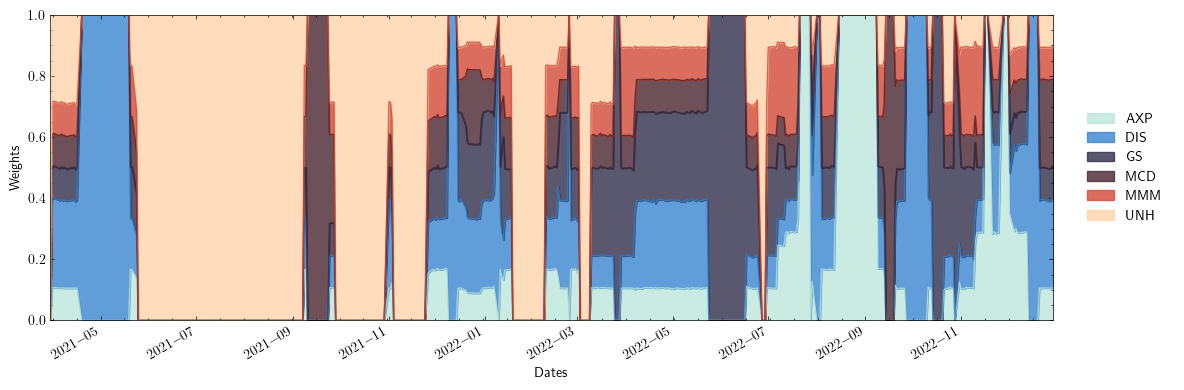

In [229]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_lstm_test_result[0].weights, ppo_lstm_test_result[0].date, ppo_lstm_test_result[1],add_cash=False)

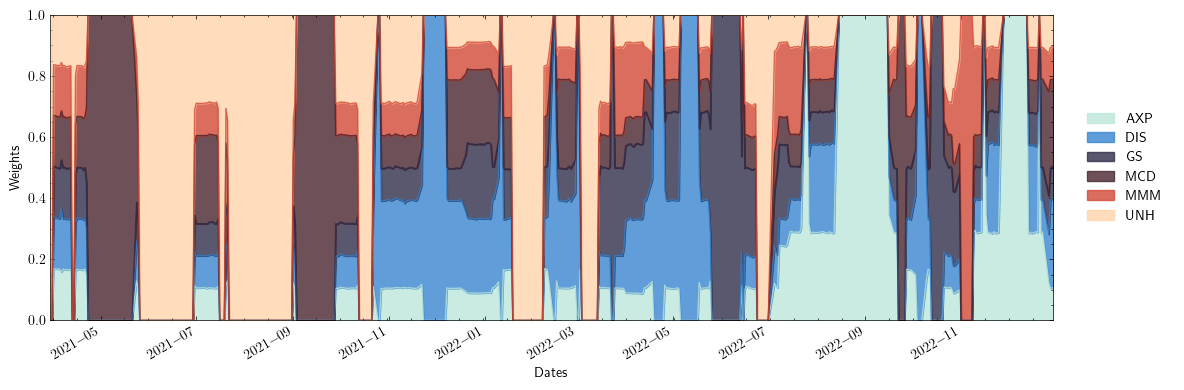

In [223]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

In [74]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=60,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 948644.0
Final accumulative portfolio value: 0.9486439824104309
Maximum DrawDown: -0.22713165755853804
Sharpe ratio: -0.06122215468658751


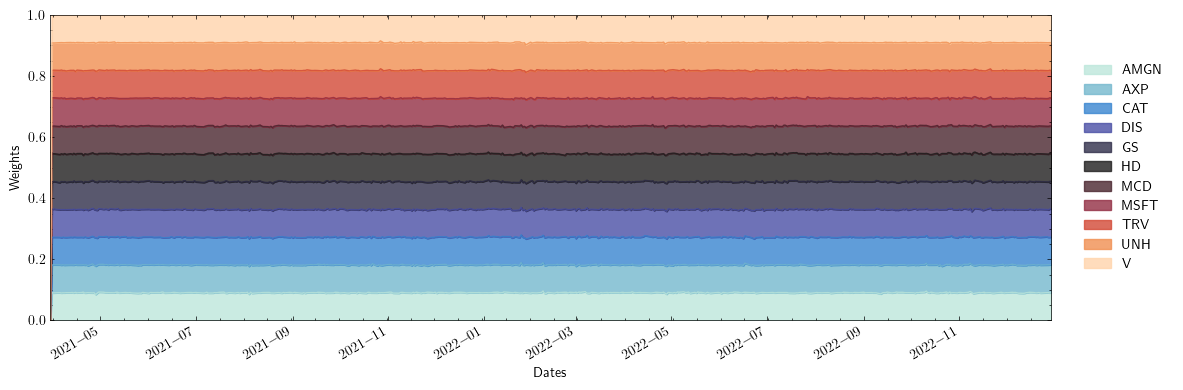

In [30]:
from utils.plotting_helpers import plot_buy_and_hold_weights
plot_buy_and_hold_weights(environment_train_buy_and_hold_sp500,test_data=test_data,ad_cash=False)

In [26]:
ppo_test_result[0]

,date,daily_return,account,weights
0,2021-03-30,0.000000,250000.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2021-03-31,-0.006214,248446.515625,"[0.044483244, 0.1200004, 0.120744735, 0.120714..."
2,2021-04-01,0.009116,250711.281250,"[0.04378715, 0.12148407, 0.119299844, 0.121720..."
3,2021-04-05,0.009144,253003.718750,"[0.04606191, 0.12506914, 0.12413302, 0.1234854..."
4,2021-04-06,-0.002756,252306.453125,"[0.04860416, 0.13375093, 0.11701457, 0.1345407..."
...,...,...,...,...
439,2022-12-23,0.005436,276824.187500,"[0.1254476, 0.083120964, 0.046838865, 0.105099..."
440,2022-12-27,-0.003511,275852.281250,"[0.110441186, 0.074421324, 0.047481943, 0.1154..."
441,2022-12-28,-0.011138,272779.718750,"[0.054806724, 0.073702134, 0.047949683, 0.1290..."
442,2022-12-29,0.015057,276887.031250,"[0.04557142, 0.08331371, 0.069486044, 0.127457..."


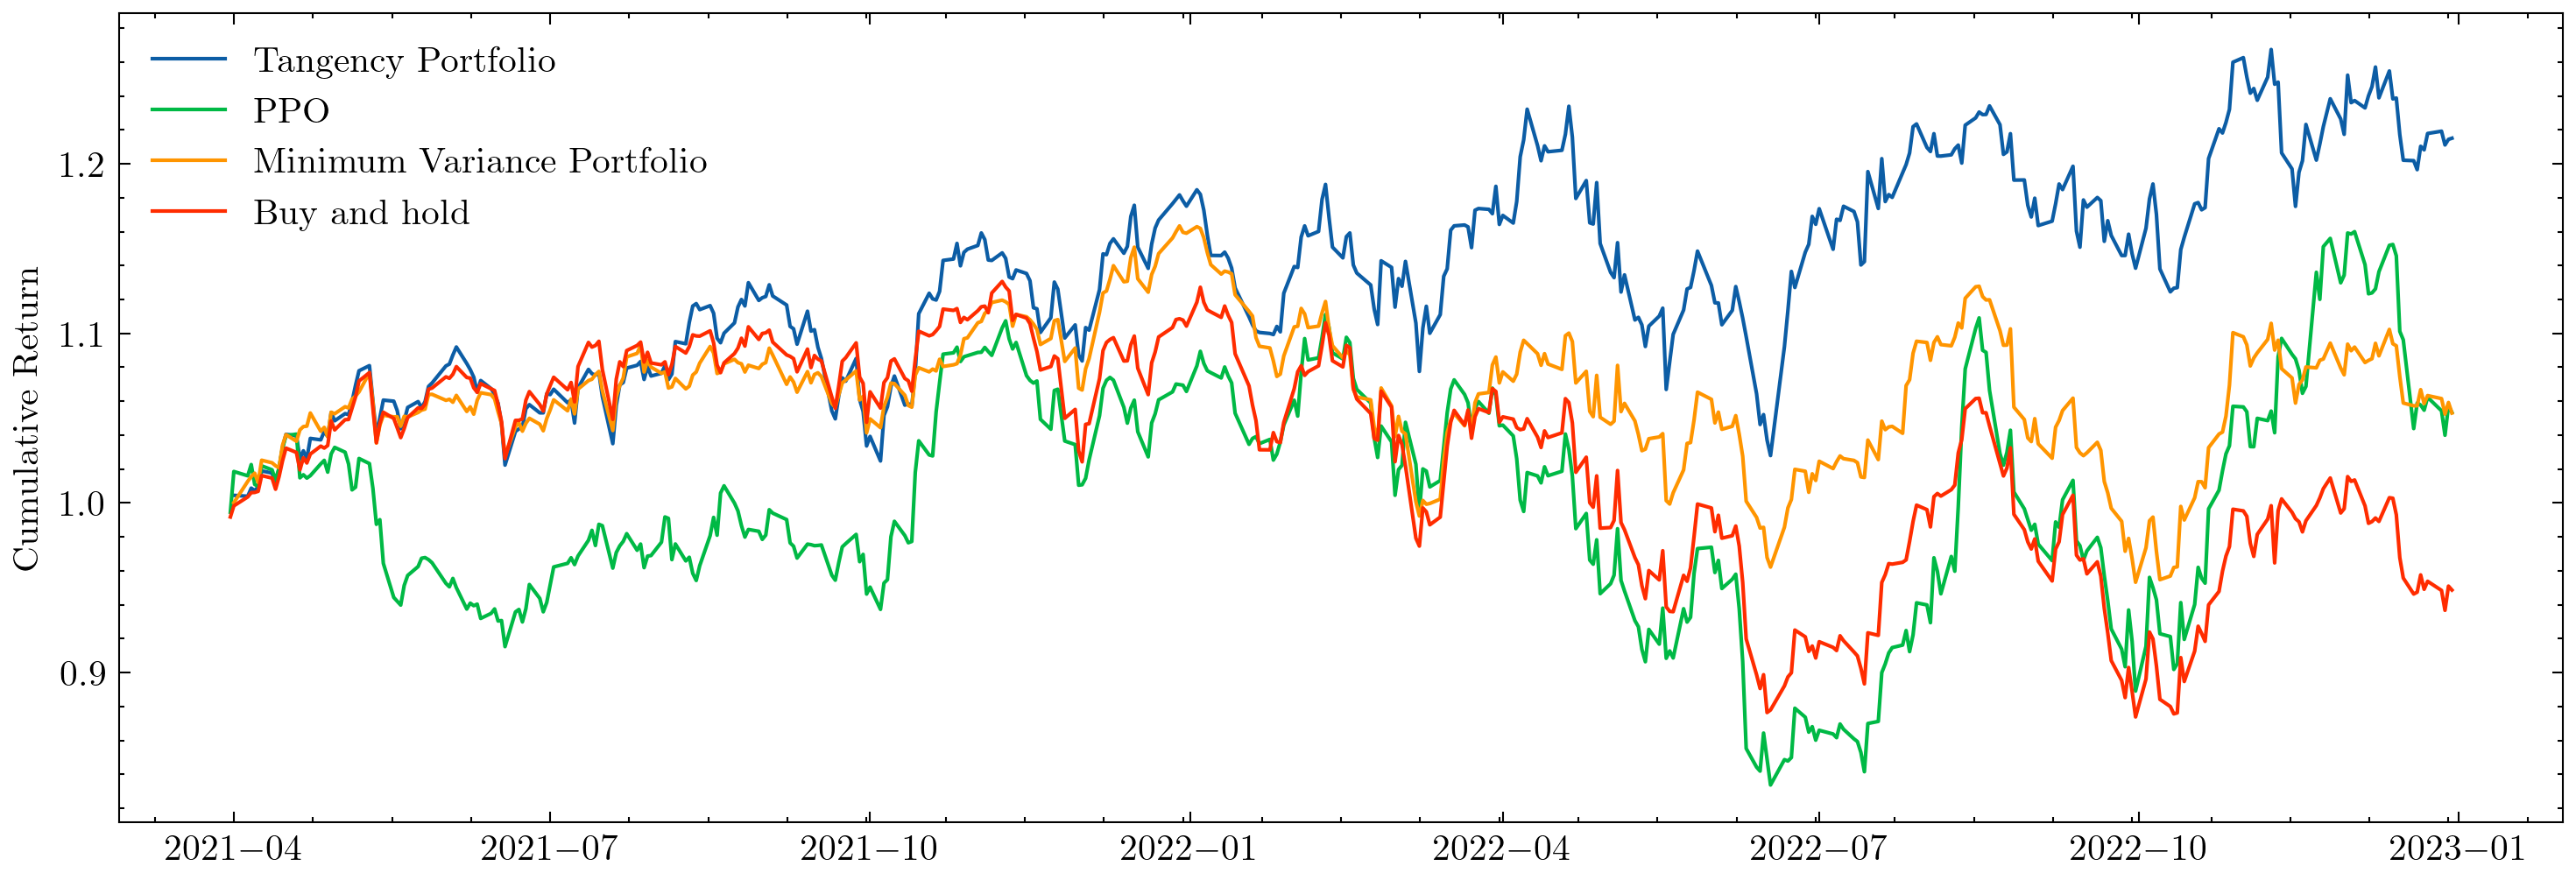

In [187]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe['test'].date,(result_sharpe['test'].total_assets.pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(min_variacen_portfolio['test'].date,(min_variacen_portfolio['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [87]:
import quantstats as qs

In [213]:
ppo_returns = ppo_test_result[0][['date','account']]

ppo_stats={}
ppo_returns.set_index('date',inplace=True)
ppo_stats['name']  = 'Proximal Policy Optimization'
ppo_stats['sharpe_ratio'] = qs.stats.sharpe(ppo_returns)['account']
ppo_stats['max_drow_down'] = qs.stats.max_drawdown(ppo_returns)['account']
ppo_stats['var'] = qs.stats.var(ppo_returns)[0].item()
ppo_stats['return'] = qs.stats.comp(ppo_returns['account'].pct_change())
ppo_stats

{'name': 'Proximal Policy Optimization',
 'sharpe_ratio': np.float64(0.3388092143131057),
 'max_drow_down': np.float64(-0.2664428956423516),
 'var': -0.02301269977821848,
 'return': np.float64(0.09390949999999965)}

In [214]:
mvo_min_returns = min_variacen_portfolio['test'][['date','total_assets']]
mvo_min_returns.set_index('date',inplace=True)

mvo_min_stats={}
mvo_min_stats['name']  = 'Min variance portfolio'
mvo_min_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_min_returns)['total_assets']
mvo_min_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_min_returns)['total_assets']
mvo_min_stats['var']  = qs.stats.var(mvo_min_returns)[0].item()
mvo_min_stats['return'] = qs.stats.comp(mvo_min_returns['total_assets'].pct_change())
mvo_min_stats

{'name': 'Min variance portfolio',
 'sharpe_ratio': np.float64(0.2633164866290335),
 'max_drow_down': np.float64(-0.18063587669076375),
 'var': -0.01639642306661718,
 'return': np.float64(0.05302095955995423)}

In [215]:

mvo_sharpe_returns = result_sharpe['test'][['date','total_assets']]
mvo_sharpe_returns.set_index('date',inplace=True)
mvo_sharpe_stats={}
mvo_sharpe_stats['name']  = 'Tangency Portfolio'
mvo_sharpe_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_sharpe_returns)['total_assets']
mvo_sharpe_stats['var']  = qs.stats.var(mvo_sharpe_returns)[0].item()
mvo_sharpe_stats['return'] = qs.stats.comp(mvo_sharpe_returns['total_assets'].pct_change())
mvo_sharpe_stats

{'name': 'Tangency Portfolio',
 'sharpe_ratio': np.float64(0.666227580986604),
 'max_drow_down': np.float64(-0.16693110888675866),
 'var': -0.019609587852893476,
 'return': np.float64(0.21507314715763637)}

In [216]:
bh_df = pd.DataFrame()
bh_df['asset']=environment_train_buy_and_hold_sp500._portfolio_return_memory
bh_df['date']=environment_train_buy_and_hold_sp500._date_memory
bh_df.set_index('date',inplace=True)
bh_stats={}
bh_stats['name']  = 'Buy and Hold'
bh_stats['sharpe_ratio'] = qs.stats.sharpe(bh_df)['asset']
bh_stats['max_drow_down'] = qs.stats.max_drawdown(bh_df)['asset']
bh_stats['var'] = qs.stats.var(bh_df)[0].item()
bh_stats['return'] = qs.stats.comp(bh_df['asset'])

bh_stats

{'name': 'Buy and Hold',
 'sharpe_ratio': np.float64(-0.06122215468658751),
 'max_drow_down': np.float64(-0.22713166127519646),
 'var': -0.019835048058484694,
 'return': np.float64(-0.051356343491552825)}

In [217]:
stats = [bh_stats,mvo_sharpe_stats,mvo_min_stats,ppo_stats]

In [218]:
stats_df = pd.DataFrame(stats)

In [219]:
stats_df

,name,sharpe_ratio,max_drow_down,var,return
0,Buy and Hold,-0.061222,-0.227132,-0.019835,-0.051356
1,Tangency Portfolio,0.666228,-0.166931,-0.019610,0.215073
2,Min variance portfolio,0.263316,-0.180636,-0.016396,0.053021
3,Proximal Policy Optimization,0.338809,-0.266443,-0.023013,0.093909


In [220]:
with open('mytable.tex', 'w') as tf:
     tf.write(stats_df.to_latex())